In [10]:
!pip install hickle

     |████████████████████████████████| 49 kB 1.2 MB/s            
     |████████████████████████████████| 2.9 MB 3.3 MB/s            
     |████████████████████████████████| 86 kB 1.3 MB/s             
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.5.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.


In [17]:
import os
import pandas as pd
import shutil
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image, ImageChops
import torch
from torch import nn
import torchvision.models
import cv2

from pathlib import Path

import tensorflow as tf
from tensorflow import keras

In [22]:
!nvidia-smi

Sun Jun  5 22:39:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   31C    P8    25W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

### Load Model

In [39]:
fundus_classifier = keras.models.load_model('models/ROP-256x25680-20-split-resnet18-Float16_2-race_detection_rop_seg_data_fundus_rop_seg-0.001_20220419-040552_epoch:021.hdf5')

In [40]:
fundus_classifier

In [41]:
segmentation_classifier = keras.models.load_model('models/MIMIC-256x25680-20-split-resnet-Float16_2-race_detection_rop_seg_data_rop_seg-0.001_20220321-054140_epoch:011.hdf5')

In [48]:
fundus_classifier.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_18[0][0]          
_______________________________________________________________________________________

In [46]:
segmentation_classifier.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_68 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_68[0][0]          
______________________________________________________________________________________

## Test Classifier

In [98]:
img = Image.open("/users/riya/race/dataset/segmentations/7445.bmp")

In [99]:
arr = np.array(img)

In [100]:
resized = cv2.resize(arr, (256, 256))

### Method 1: 2D image repeated thrice - to make three channels

In [117]:
channels = np.repeat(resized[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))

In [118]:
arr.shape, resized.shape, channels.shape

((480, 640), (256, 256), (1, 256, 256, 3))

In [119]:
# unnecessary 
tensor = tf.convert_to_tensor(channels)

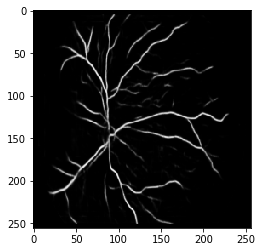

In [120]:
plt.imshow(np.reshape(channels, (256, 256, 3)), interpolation='nearest')
plt.show()

In [121]:
# right pred 
segmentation_classifier(channels)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0647717, 0.9352283]], dtype=float32)>

In [279]:
tensor = segmentation_classifier(channels)

In [314]:
tensor

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0647717, 0.9352283]], dtype=float32)>

In [313]:
tensor.numpy()[0,1]

0.9352283

### Method 2: Concatenate zeroed channels

In [122]:
# concatenate zero channels
zeros = np.zeros((256, 256, 1))
resized1 = np.reshape(resized, (256, 256, 1))
resized1.shape

(256, 256, 1)

In [123]:
channels1 = np.concatenate((resized1, zeros, zeros), axis = 2).reshape((1,256,256,3))

In [124]:
channels1.shape

(1, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


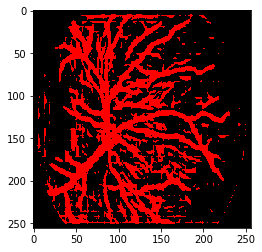

In [125]:
plt.imshow(np.reshape(channels1, (256, 256, 3)), interpolation='nearest')
plt.show()

In [126]:
# wrong pred 
segmentation_classifier(channels1)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.863334  , 0.13666598]], dtype=float32)>

Ok! We know what we want :)

## High Intensity Pixel Images

I need to take images and black out pixels of highest intensity in main and background regions. To do this, I'll first choose some number of images with similar main and background locations (manually), load those into my new folder, and remove high intensity pixels there.

Images: 7393, 7419, 7420, 7423, 7568, 7571, 7575, 7578, 9135, 9153, 9378, 9394, 9540, 9556, 12013, 12018, 12487, 12488, 15880, 18163

### Load Images

In [154]:
ids = [7393, 7419, 7420, 7423, 7568, 7571, 7575, 7578, 9135, 9153, 9378, 9394, 9540, 9556, 12013, 12018, 12487, 12488, 15880, 18163]

In [166]:
csv_path = "/users/riya/race/csv/image_race_data.csv"
data_path = "/users/riya/race/dataset/segmentations/"
intensity_path = "/users/riya/classifier_experiments/dataset/high_intensity/original/"

In [156]:
def get_images(ids, csv_path, load_path, save_path):
    
    new_df = pd.DataFrame()
    data = pd.read_csv(csv_path)
        
    for i in ids:
        a = shutil.copy(store_path + str(i) + '.bmp', load_path) # solely copying segmentations
        
        df1 = data.loc[data['image_id'] == i]
        new_df = pd.concat([new_df, df1], axis = 0)
    
    return new_df

In [157]:
data20 = get_images(ids, csv_path, data_path, intensity_path)

In [277]:
data20

,subject_id,race,variable,value,image_id,fundus_location,segmentation_location
1019,RCOL-0022-JS,black,posterior,https://tctc.ohsu.edu/uploads/7393.png,7393,7393.png,7393.bmp
3588,RCOL-0026-MM,black,nasal,https://tctc.ohsu.edu/uploads/7419.png,7419,7419.png,7419.bmp
1020,RCOL-0026-MM,black,posterior,https://tctc.ohsu.edu/uploads/7420.png,7420,7420.png,7420.bmp
1021,RCOL-0026-MM,black,posterior,https://tctc.ohsu.edu/uploads/7423.png,7423,7423.png,7423.bmp
1027,RCOL-0042-EW,white,posterior,https://tctc.ohsu.edu/uploads/7568.png,7568,7568.png,7568.bmp
1028,RCOL-0042-EW,white,posterior,https://tctc.ohsu.edu/uploads/7571.png,7571,7571.png,7571.bmp
1029,RCOL-0042-EW,white,posterior,https://tctc.ohsu.edu/uploads/7575.png,7575,7575.png,7575.bmp
1030,RCOL-0042-EW,white,posterior,https://tctc.ohsu.edu/uploads/7578.png,7578,7578.png,7578.bmp
731,OHSU-0006,white,posterior,https://tctc.ohsu.edu/uploads/9135.bmp,9135,9135.png,9135.bmp
735,OHSU-0007,white,posterior,https://tctc.ohsu.edu/uploads/9153.bmp,9153,9153.png,9153.bmp


Immediate note: many more white than black patients.

### Find the Boundary

By looking at the images: 
 * preliminary x: 75 to 125
 * preliminary y: 100 to 150
 
(determined by manually looking at images and finding general patterns in central region location)

In [159]:
def find_boundary(ids, load_path):
    for i in ids:
        img = Image.open(load_path + str(i) + '.bmp')
        resized = cv2.resize(np.array(img), (256, 256))
        
        plt.imshow(resized, interpolation='nearest')
        plt.show()

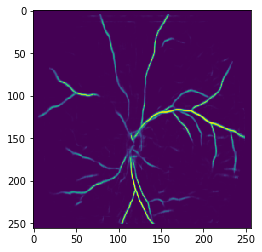

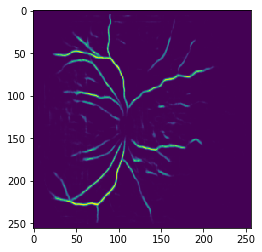

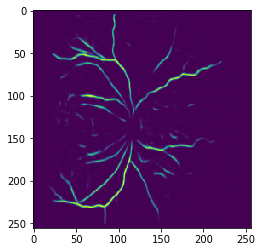

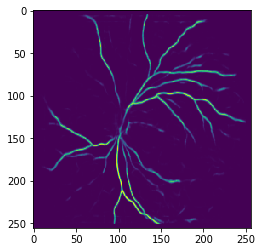

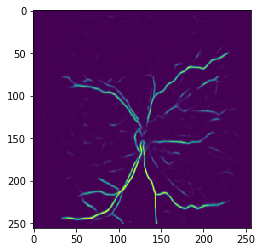

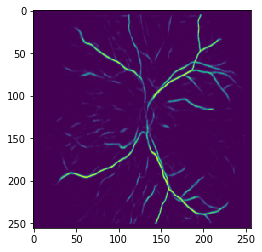

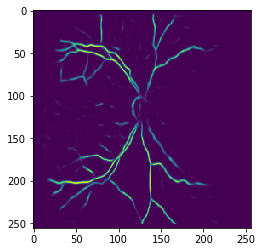

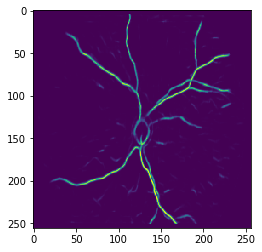

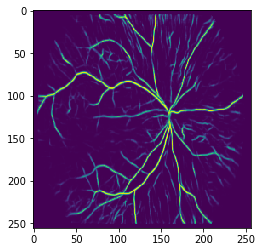

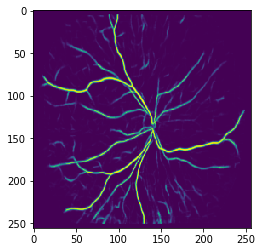

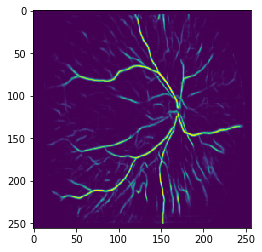

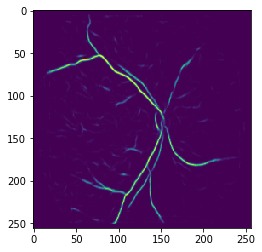

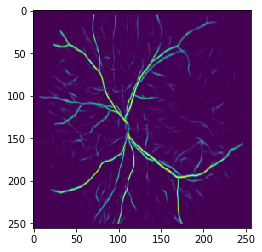

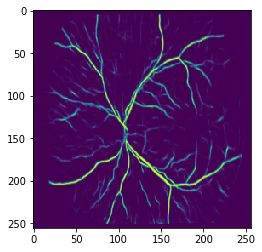

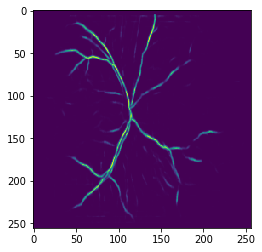

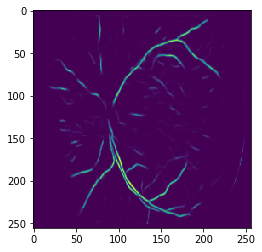

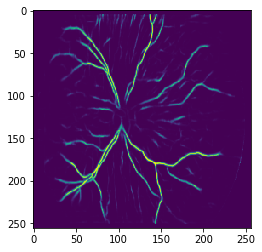

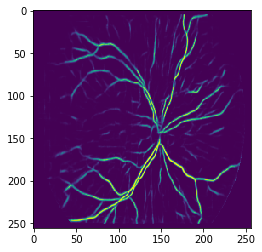

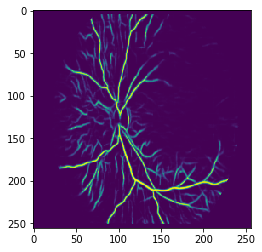

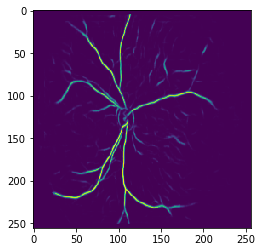

In [160]:
find_boundary(ids, load_path)

### Shadow Images

In [268]:
dull_center_path = "/users/riya/classifier_experiments/dataset/high_intensity/dull_center/"
dull_back_path = "/users/riya/classifier_experiments/dataset/high_intensity/dull_back/"

In [331]:
def shadow_images(ids, load_path, save_path1, save_path2, threshold, region):
    for i in ids:
        img = Image.open(load_path + str(i) + '.bmp')
        resized = cv2.resize(np.array(img), (256, 256))
        
        x_bottom = 50
        x_top = 150
        
        y_bottom = 75
        y_top = 175
        
        # remove brightest pixels from center
        center_arr = resized[y_bottom:y_top, x_bottom:x_top] # idk why switched works?
        dull_center = np.copy(center_arr)
        dull_center[dull_center > threshold] = 0 # goes from 0 to 246
        
            # pad and concat
        center_arr = np.pad(center_arr, ((y_bottom, 256 - y_top), (x_bottom, 256 - x_top)))
        dull_center = np.pad(dull_center, ((y_bottom, 256 - y_top), (x_bottom, 256 - x_top)))
        final_center = resized - center_arr + dull_center

        # remove brightest pixels from background
        back_arr = resized - center_arr # 0 for center pixels
        dull_back = np.copy(back_arr)
        dull_back[dull_back > threshold] = 0 # goes from 0 to 246
        final_back = dull_back + center_arr
        
        if (region == 'center'):
            center_img = Image.fromarray(final_center)
            center_img.save(save_path1 + str(i) + '.bmp')
        elif (region == 'background'):
            back_img = Image.fromarray(final_back)
            back_img.save(save_path2 + str(i) + '.bmp')
            
        # same filenames because stored in different folders

In [334]:
shadow_images(ids, intensity_path, dull_center_path, dull_back_path, 100, 'background')

In [335]:
shadow_images(ids, intensity_path, dull_center_path, dull_back_path, 100, 'center')

From the first run, it appears I made the dull region for the center much too small, since dull center is barely any different. We will make the region larger and then test the classifier.

Done that! Increased the region by 25 pixels on both sides.

### Prepare For Classifier

The idea is that I'll return the **prediction for the white class** for dull center, dull back, and more.

In [428]:
def prepare_for_classification(img_id, img_path):
    img = Image.open(img_path + str(img_id) + '.bmp')
    arr = np.array(img)
    resized = cv2.resize(arr, (256, 256))
    channels = np.repeat(resized[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))
    
    return channels

In [429]:
og_imgs = np.zeros([1, 256, 256, 3], dtype='int')
dull_back_imgs = np.zeros([1, 256, 256, 3], dtype='int')
dull_center_imgs = np.zeros([1, 256, 256, 3], dtype='int')

In [430]:
def combine_images(ids, img_path, img_arr):
    for i in ids:
        # original preds
        img_prepared = prepare_for_classification(i, img_path)
        img_arr = np.concatenate((img_arr, img_prepared), axis = 0)
    
    return img_arr

In [431]:
og_imgs = combine_images(ids, intensity_path, og_imgs)
dull_back_imgs = combine_images(ids, dull_back_path, dull_back_imgs)
dull_center_imgs = combine_images(ids, dull_center_path, dull_center_imgs)

In [432]:
dull_back_imgs.shape, dull_center_imgs.shape, og_imgs.shape 

# first prediction is just done with all zeros, i'm not sure how to avoid that.

((21, 256, 256, 3), (21, 256, 256, 3), (21, 256, 256, 3))

### Run Through Classifier & Predictions

In [434]:
preds_df = pd.DataFrame(columns = ['id', 'og_pred', 'dull_center_pred', 'dull_back_pred'])

In [435]:
pred_ids = pd.Series(ids)
pred_ids = pd.concat([pd.Series([0]), pred_ids]) # the first prediction is irrelevant, so accounting for that

In [436]:
preds_df['id'] = pred_ids

In [437]:
preds_df.head()

,id,og_pred,dull_center_pred,dull_back_pred
0,0,NaN,NaN,NaN
0,7393,NaN,NaN,NaN
1,7419,NaN,NaN,NaN
2,7420,NaN,NaN,NaN
3,7423,NaN,NaN,NaN


In [438]:
def determine_preds(preds_df, name, images):

    num_images = images.shape[0]
    preds_arr = [0] * num_images

    preds = segmentation_classifier(images)
    
    for i in range(num_images):
        preds_arr[i] = preds.numpy()[i, 1] # returning the white prediction for each image
    
    preds_df[name] = preds_arr # weird that not defined in function?

In [439]:
determine_preds(preds_df, 'og_pred', og_imgs)

In [440]:
determine_preds(preds_df, 'dull_center_pred', dull_center_imgs)
determine_preds(preds_df, 'dull_back_pred', dull_back_imgs)

In [441]:
preds_df

,id,og_pred,dull_center_pred,dull_back_pred
0,0,0.918845,0.918845,0.918845
0,7393,0.000611,0.000981,0.009038
1,7419,0.000732,0.000534,0.845560
2,7420,0.000229,0.000438,0.184327
3,7423,0.006811,0.030647,0.770983
4,7568,0.997708,0.949248,0.999769
5,7571,0.995381,0.984396,0.999874
6,7575,0.839800,0.661759,0.999395
7,7578,0.998232,0.876634,0.999840
8,9135,0.999997,0.999998,0.999998


Very interesting! Turns out for 3/4 of the black images, dulling the back regions seems to greatly increase prediction of white class, although not applying vice versa. Let's try more black images and see if this continues to apply.

Generally, the white images seem to not be affected. The probability is slightly lowered for most when the center is blacked out, and more largely influenced for three of the images.